In [1]:
import pandas as pd
import numpy as np

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from lime.lime_tabular import LimeTabularExplainer
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report, confusion_matrix, ConfusionMatrixDisplay
)
import matplotlib.pyplot as plt
import joblib

from sklearn.inspection import permutation_importance

RANDOM_STATE = 42
TARGET_COL = "Target"   

In [2]:
train = pd.read_csv('../Data/train.csv') 
test = pd.read_csv('../Data/test.csv')

X_train = train.drop(columns=[TARGET_COL])
y_train = train[TARGET_COL].astype(int)

X_test = test.drop(columns=[TARGET_COL])
y_test = test[TARGET_COL].astype(int)

print(X_train.shape, X_test.shape, y_train.value_counts().to_dict())

(5301, 40) (885, 40) {2: 1767, 0: 1767, 1: 1767}


In [3]:
pipe = Pipeline([
    ("scaler", StandardScaler(with_mean=True, with_std=True)),
    ("knn", KNeighborsClassifier())
])

# Espaço de busca:
# - k ímpares para evitar empates
# - pesos uniform vs distance
# - métrica Euclidiana (p=2) e Manhattan (p=1)
param_grid = {
    "knn__n_neighbors": [3,5,7,9,11,13,15,17,19,21,25,29,31],
    "knn__weights": ["uniform", "distance"],
    "knn__metric": ["minkowski"],
    "knn__p": [1, 2]  # 1=Manhattan, 2=Euclidiana
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

scoring = {
    "accuracy": "accuracy",
    "macro_f1": "f1_macro",
    "weighted_f1": "f1_weighted"
}

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scoring,
    refit="macro_f1",
    cv=cv,
    n_jobs=-1,
    verbose=1
)

grid.fit(X_train, y_train)

print("Melhores hiperparâmetros:", grid.best_params_)
print("Melhor F1-macro (CV):", grid.best_score_)

Fitting 5 folds for each of 52 candidates, totalling 260 fits
Melhores hiperparâmetros: {'knn__metric': 'minkowski', 'knn__n_neighbors': 3, 'knn__p': 1, 'knn__weights': 'distance'}
Melhor F1-macro (CV): 0.8210293607662067


Acurácia (test): 0.6384
Macro-Precision: 0.5887 | Macro-Recall: 0.5749 | Macro-F1: 0.5780
Weighted-Precision: 0.6587 | Weighted-Recall: 0.6384 | Weighted-F1: 0.6455

Classification Report (por classe):

              precision    recall  f1-score   support

   0=Dropout     0.7316    0.5951    0.6563       284
  1=Enrolled     0.2900    0.3648    0.3231       159
  2=Graduate     0.7445    0.7647    0.7545       442

    accuracy                         0.6384       885
   macro avg     0.5887    0.5749    0.5780       885
weighted avg     0.6587    0.6384    0.6455       885



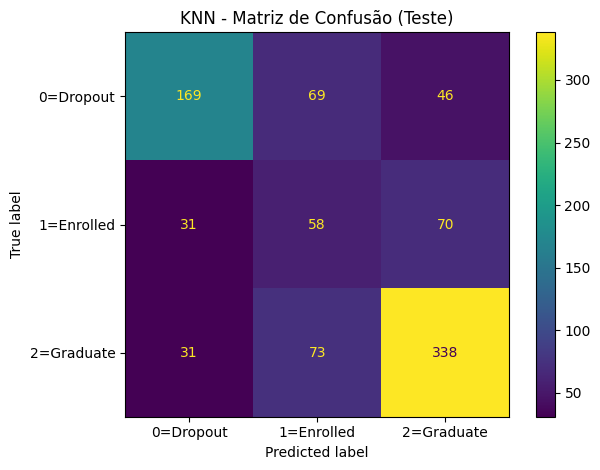

In [4]:
best_model = grid.best_estimator_

y_pred = best_model.predict(X_test)

def predict_proba_df(X):
    X_df = pd.DataFrame(X, columns=X_train.columns)
    return best_model.predict_proba(X_df)


acc = accuracy_score(y_test, y_pred)
prec, rec, f1, support = precision_recall_fscore_support(
    y_test, y_pred, average=None, labels=[0,1,2]
)
macro_prec, macro_rec, macro_f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="macro"
)
weighted_prec, weighted_rec, weighted_f1, _ = precision_recall_fscore_support(
    y_test, y_pred, average="weighted"
)

print(f"Acurácia (test): {acc:.4f}")
print(f"Macro-Precision: {macro_prec:.4f} | Macro-Recall: {macro_rec:.4f} | Macro-F1: {macro_f1:.4f}")
print(f"Weighted-Precision: {weighted_prec:.4f} | Weighted-Recall: {weighted_rec:.4f} | Weighted-F1: {weighted_f1:.4f}")

target_names = ["0=Dropout", "1=Enrolled", "2=Graduate"]
print("\nClassification Report (por classe):\n")
print(classification_report(y_test, y_pred, target_names=target_names, digits=4))

cm = confusion_matrix(y_test, y_pred, labels=[0,1,2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)
disp.plot(values_format="d")
plt.title("KNN - Matriz de Confusão (Teste)")
plt.tight_layout()
plt.show()

# Interpretabilidade — K-NN
O K-NN não possui parâmetros globais; cada predição depende dos vizinhos no espaço das features. Para explicar decisões:
- visão global: Importância de Permutação (queda de F1-macro ao embaralhar cada coluna);
- visão local: LIME em 3 exemplos (acerto, erro e aleatório).

#### Importância de Permutação (F1-macro)
Mede a queda média de F1-macro no teste quando embaralhamos uma coluna. Quanto maior a queda, mais a feature impacta a decisão do K-NN.


,feature,mean_importance,std_importance
36,Tuition fees up to date_1,0.021638,0.004128
35,Debtor_1,0.013934,0.006883
21,Curricular units 2nd sem (approved),0.013808,0.005835
15,Curricular units 1st sem (approved),0.010338,0.005486
27,Marital status_2,0.004260,0.003339
32,Daytime/evening attendance\t_1,0.004216,0.002271
34,Educational special needs_1,0.003748,0.002036
20,Curricular units 2nd sem (evaluations),0.002521,0.005871
22,Curricular units 2nd sem (grade),0.002165,0.005613
28,Marital status_3,0.000054,0.000508


/var/folders/65/vv85rmjn45n542spj91c2kb80000gn/T/ipykernel_31611/3445996589.py:36: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/alicecestari/Library/Python/3.9/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 9 (	) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


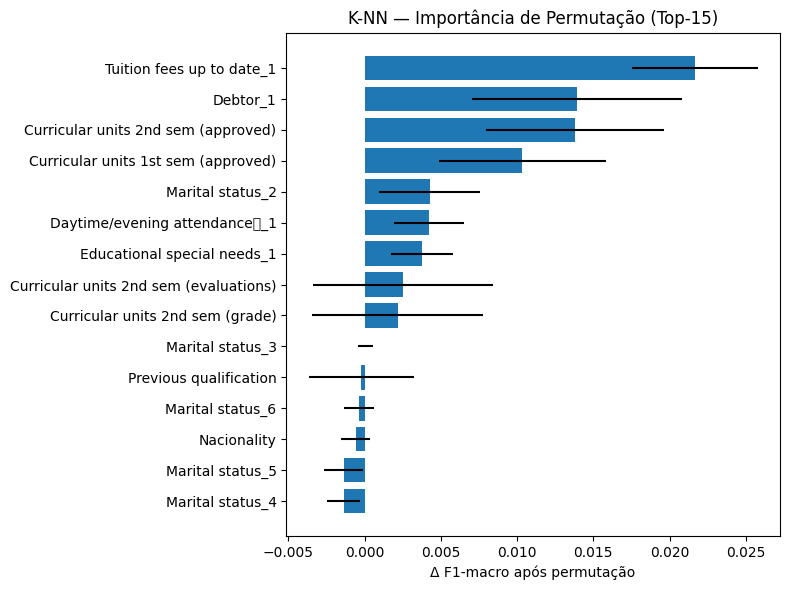

In [ ]:

# Usaremos F1-macro porque é a métrica-alvo do GridSearch
perm_result = permutation_importance(
    estimator=best_model,
    X=X_test,
    y=y_test,
    scoring="f1_macro",
    n_repeats=20,
    random_state=RANDOM_STATE,
    n_jobs=-1
)

imp_df = (
    pd.DataFrame(
        {
            "feature": X_train.columns,
            "mean_importance": perm_result.importances_mean,
            "std_importance": perm_result.importances_std,
        }
    )
    .sort_values("mean_importance", ascending=False)
)

display(imp_df.head(15))

# Plot
plt.figure(figsize=(8, 6))
plt.barh(
    y=imp_df["feature"].head(15)[::-1],
    width=imp_df["mean_importance"].head(15)[::-1],
    xerr=imp_df["std_importance"].head(15)[::-1],
)
plt.xlabel("Δ F1-macro após permutação")
plt.title("K-NN — Importância de Permutação (Top-15)")
plt.tight_layout()
plt.show()

#### LIME — explicações locais
Vamos explicar 3 exemplos (1 acerto, 1 erro, 1 aleatório) com LIME. Os gráficos mostram a contribuição local (positiva/negativa) das features para a classe prevista.

In [6]:
class_names = ["Dropout", "Enrolled", "Graduate"]

explainer = LimeTabularExplainer(
    training_data=X_train.values,
    feature_names=X_train.columns.tolist(),
    class_names=class_names,
    mode="classification",
    discretize_continuous=False,
    sample_around_instance=True,
    random_state=RANDOM_STATE
)


idx=0 | true=Graduate | pred=Graduate
  Curricular units 2nd sem (approved): +0.126
  Curricular units 1st sem (evaluations): -0.089
  Curricular units 1st sem (approved): +0.077
  Curricular units 1st sem (grade): +0.064
  Gender_1: -0.063
  Course: -0.046
  Mother's qualification: +0.038
  Curricular units 2nd sem (grade): +0.035
  Father's qualification: +0.028
  Previous qualification: +0.020


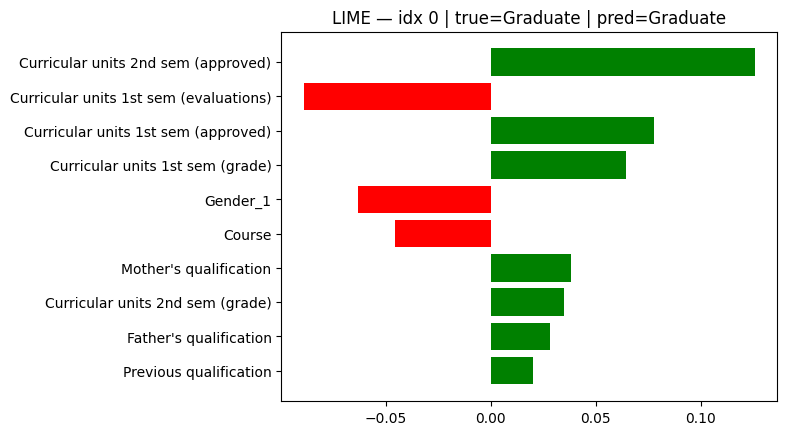


idx=2 | true=Enrolled | pred=Dropout
  Curricular units 2nd sem (approved): -0.092
  Application mode: +0.068
  Curricular units 2nd sem (grade): -0.063
  Mother's qualification: -0.043
  Gender_1: +0.031
  Father's occupation: -0.031
  Course: +0.027
  Father's qualification: -0.018
  Previous qualification (grade): -0.016
  Unemployment rate: +0.016


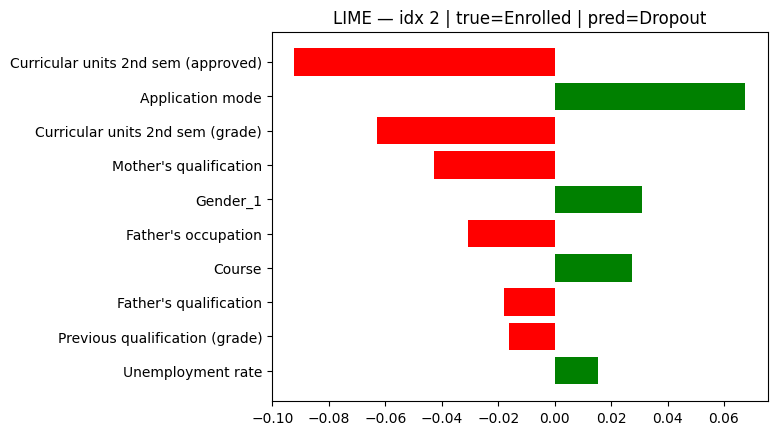


idx=525 | true=Enrolled | pred=Dropout
  Curricular units 2nd sem (grade): -0.070
  Curricular units 2nd sem (approved): -0.066
  Curricular units 1st sem (approved): -0.053
  Father's qualification: -0.046
  Father's occupation: -0.043
  GDP: +0.034
  Inflation rate: +0.032
  Previous qualification (grade): -0.032
  Unemployment rate: +0.019
  Application order: -0.019


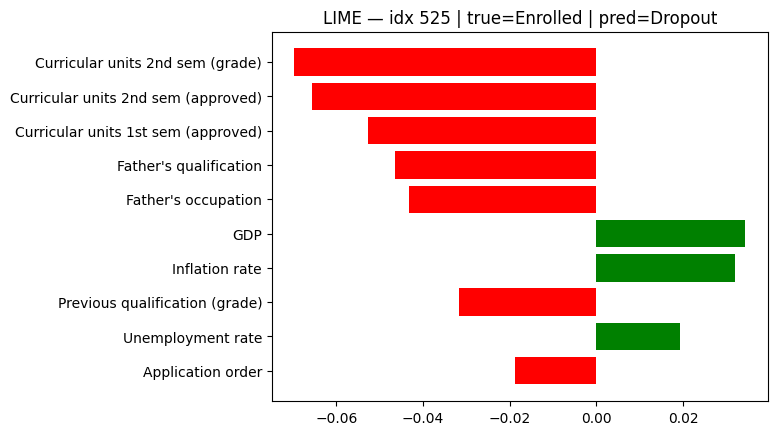

In [ ]:
idxs = [
    int(np.where(y_pred == y_test.values)[0][0]),  # primeiro acerto
    int(np.where(y_pred != y_test.values)[0][0]),  # primeiro erro
    int(np.random.randint(0, len(X_test)))         # aleatório
]

for i in idxs:
    exp = explainer.explain_instance(
        X_test.iloc[i].values,
        predict_fn=predict_proba_df,
        num_features=10,
        top_labels=1
    )
    true_label = int(y_test.iloc[i])
    pred_label = int(y_pred[i])

    print(f"\nidx={i} | true={class_names[true_label]} | "
          f"pred={class_names[pred_label]}")
    for feat, w in exp.as_list(label=pred_label):
        print(f"  {feat}: {w:+.3f}")

    fig = exp.as_pyplot_figure(label=pred_label)
    plt.title(f"LIME — idx {i} | true={class_names[true_label]} "
              f"| pred={class_names[pred_label]}")
    plt.show()

#### Análise
- Global (Permutação): `Tuition fees up to date_1` e `Debtor_1` lideram, seguidos por desempenho curricular (aprovadas 1º/2º sem). Isso indica que adimplência/devedor e rendimento recente impactam diretamente o F1 no teste.
- Local (LIME):
  - Acerto (Graduate): contribuições positivas de “Curricular units 2nd sem (approved)” e aprovações/notas do 1º semestre.
  - Erros (Enrolled→Dropout): “Curricular units 2nd sem (approved/grade)” puxam contra a classe prevista; “Application mode/order” e macroeconômicas às vezes empurram a favor do Dropout.
- K-NN é sensível à vizinhança — variáveis com grande separação local (aprovadas/notas, adimplência) tendem a dominar a decisão. As explicações variam por instância, reforçando o uso conjunto de permutação (global) e LIME (local).
